## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [8]:
import os
import keras
import itertools

# Disable GPU，若有 GPU 且想開啟，可設為 "0"，不需使用 GPU, 將 GPU 設定為 ""
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# 用 Keras 來構建一個分類神經網絡，用到的數據集是 MNIST，就是 0 到 9 這幾個數字的圖片數據集。
# 從 Keras 的內建功能中，取得 cifar10 train 與 test 資料集
train, test = keras.datasets.cifar10.load_data()

In [3]:
# 資料前處理 - 標準化
# 因為每個像素都是在 0 到 255 之間的，標準化之後就變成了 0 到 1 之間。
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
# X 是一張張圖片，Y 是每張圖片對應的標籤，即它是哪個數字。
# 將 X 與 Y 獨立放進變數
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
# 資料前處理 - X 標準化，在上一個區塊已經定義了preproc_x的功能
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
# 資料前處理 -Y 轉成 onehot，在上一個區塊已經定義了preproc_y的功能
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

##比較使用 l1, l1_l2 及不同比例下的訓練結果

In [17]:
from keras.regularizers import l1

In [14]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [15]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [18]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-accuracy': train_acc,
                             'valid-accuracy': valid_acc}

Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====

50000/50000 [==============================] - 9s 182us/step - loss: 2.4626 - accuracy: 0.0986 - val_loss: 2.4624 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 9s 185us/step - loss: 2.4626 - accuracy: 0.0987 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 9s 184us/step - loss: 2.4626 - accuracy: 0.0979 - val_loss: 2.4625 - val_accuracy: 0.1000
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________

50000/50000 [==============================] - 9s 187us/step - loss: 2.8306 - accuracy: 0.6187 - val_loss: 3.1367 - val_accuracy: 0.5142
Epoch 46/50
50000/50000 [==============================] - 9s 183us/step - loss: 2.7973 - accuracy: 0.6156 - val_loss: 3.1909 - val_accuracy: 0.4796
Epoch 47/50
50000/50000 [==============================] - 9s 185us/step - loss: 2.7538 - accuracy: 0.6209 - val_loss: 2.9927 - val_accuracy: 0.5389
Epoch 48/50
50000/50000 [==============================] - 9s 182us/step - loss: 2.7150 - accuracy: 0.6236 - val_loss: 2.9606 - val_accuracy: 0.5360
Epoch 49/50
50000/50000 [==============================] - 9s 185us/step - loss: 2.6751 - accuracy: 0.6263 - val_loss: 2.9326 - val_accuracy: 0.5271
Epoch 50/50
50000/50000 [==============================] - 9s 185us/step - loss: 2.6395 - accuracy: 0.6267 - val_loss: 2.9678 - val_accuracy: 0.5062
Experiment with Regulizer = 0.000000
Model: "model_1"
________________________________________________________________

50000/50000 [==============================] - 10s 192us/step - loss: 0.9576 - accuracy: 0.6613 - val_loss: 1.4314 - val_accuracy: 0.5130
Epoch 43/50
50000/50000 [==============================] - 9s 190us/step - loss: 0.9501 - accuracy: 0.6645 - val_loss: 1.3371 - val_accuracy: 0.5377
Epoch 44/50
50000/50000 [==============================] - 9s 185us/step - loss: 0.9392 - accuracy: 0.6681 - val_loss: 1.4321 - val_accuracy: 0.5162
Epoch 45/50
50000/50000 [==============================] - 9s 189us/step - loss: 0.9274 - accuracy: 0.6722 - val_loss: 1.4079 - val_accuracy: 0.5220
Epoch 46/50
50000/50000 [==============================] - 9s 186us/step - loss: 0.9117 - accuracy: 0.6779 - val_loss: 1.5758 - val_accuracy: 0.4891
Epoch 47/50
50000/50000 [==============================] - 9s 190us/step - loss: 0.9036 - accuracy: 0.6817 - val_loss: 1.3764 - val_accuracy: 0.5316
Epoch 48/50
50000/50000 [==============================] - 9s 188us/step - loss: 0.8901 - accuracy: 0.6875 - val_loss

Epoch 40/50
50000/50000 [==============================] - 9s 187us/step - loss: 0.9855 - accuracy: 0.6528 - val_loss: 1.3244 - val_accuracy: 0.5333
Epoch 41/50
50000/50000 [==============================] - 9s 186us/step - loss: 0.9759 - accuracy: 0.6572 - val_loss: 1.3473 - val_accuracy: 0.5364
Epoch 42/50
50000/50000 [==============================] - 9s 183us/step - loss: 0.9630 - accuracy: 0.6618 - val_loss: 1.3985 - val_accuracy: 0.5178
Epoch 43/50
50000/50000 [==============================] - 9s 186us/step - loss: 0.9511 - accuracy: 0.6651 - val_loss: 1.4526 - val_accuracy: 0.5144
Epoch 44/50
50000/50000 [==============================] - 9s 182us/step - loss: 0.9392 - accuracy: 0.6699 - val_loss: 1.4450 - val_accuracy: 0.5179
Epoch 45/50
50000/50000 [==============================] - 9s 185us/step - loss: 0.9288 - accuracy: 0.6726 - val_loss: 1.4016 - val_accuracy: 0.5235
Epoch 46/50
50000/50000 [==============================] - 9s 182us/step - loss: 0.9143 - accuracy: 0.6786

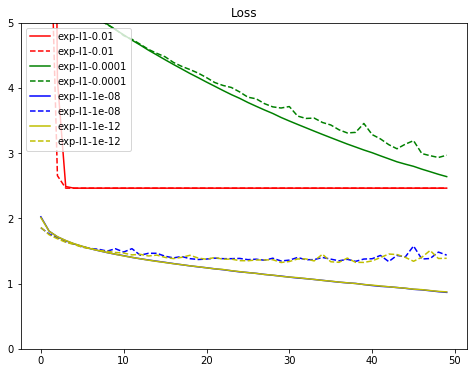

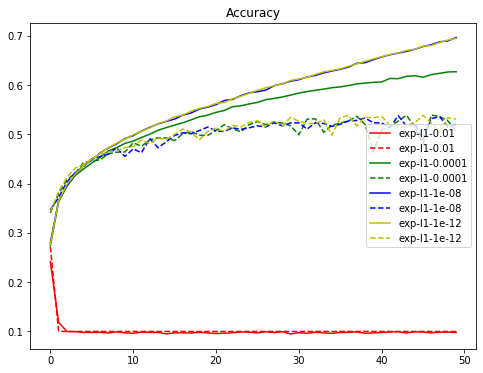

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-accuracy'])),results[cond]['train-accuracy'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-accuracy'])),results[cond]['valid-accuracy'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

##比較使用 l1, l1_l2 及不同比例下的訓練結果

In [5]:
from keras.regularizers import l1_l2

"""
建立神經網路，並加入 L1_L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128],  l1_ratio=0.0, l2_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 20
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]

In [9]:
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""

results = {}

for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-accuracy': train_acc,
                             'valid-accuracy': valid_acc}

Experiment with L1 = 0.010000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/500

Experiment with L1 = 0.010000, L2 = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/500

50000/50000 [==============================] - 12s 234us/step - loss: 2.4626 - accuracy: 0.0970 - val_loss: 2.4625 - val_accuracy: 0.1000
Experiment with L1 = 0.010000, L2 = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 

50000/50000 [==============================] - 11s 229us/step - loss: 2.5157 - accuracy: 0.4509 - val_loss: 2.4485 - val_accuracy: 0.4515
Epoch 20/20
50000/50000 [==============================] - 11s 229us/step - loss: 2.3871 - accuracy: 0.4510 - val_loss: 2.3433 - val_accuracy: 0.4412
Experiment with L1 = 0.000100, L2 = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
________________________________________________________

Epoch 19/20
50000/50000 [==============================] - 11s 225us/step - loss: 4.2196 - accuracy: 0.5374 - val_loss: 4.3138 - val_accuracy: 0.4928
Epoch 20/20
50000/50000 [==============================] - 11s 223us/step - loss: 4.1523 - accuracy: 0.5425 - val_loss: 4.2238 - val_accuracy: 0.4967
Experiment with L1 = 0.000100, L2 = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
____________________________________________

50000/50000 [==============================] - 9s 186us/step - loss: 4.2849 - accuracy: 0.5324 - val_loss: 4.3351 - val_accuracy: 0.4955
Epoch 19/20
50000/50000 [==============================] - 9s 188us/step - loss: 4.2146 - accuracy: 0.5357 - val_loss: 4.2824 - val_accuracy: 0.4983
Epoch 20/20
50000/50000 [==============================] - 9s 184us/step - loss: 4.1477 - accuracy: 0.5424 - val_loss: 4.2335 - val_accuracy: 0.4905
Experiment with L1 = 0.000000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________

Epoch 18/20
50000/50000 [==============================] - 11s 222us/step - loss: 1.4480 - accuracy: 0.5391 - val_loss: 1.5499 - val_accuracy: 0.4959
Epoch 19/20
50000/50000 [==============================] - 11s 220us/step - loss: 1.4289 - accuracy: 0.5473 - val_loss: 1.5338 - val_accuracy: 0.5030
Epoch 20/20
50000/50000 [==============================] - 11s 221us/step - loss: 1.4140 - accuracy: 0.5507 - val_loss: 1.5347 - val_accuracy: 0.4981
Experiment with L1 = 0.000000, L2 = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
__________________________

Epoch 18/20
50000/50000 [==============================] - 11s 225us/step - loss: 1.3109 - accuracy: 0.5391 - val_loss: 1.4548 - val_accuracy: 0.4833
Epoch 19/20
50000/50000 [==============================] - 11s 221us/step - loss: 1.2923 - accuracy: 0.5447 - val_loss: 1.4085 - val_accuracy: 0.4955
Epoch 20/20
50000/50000 [==============================] - 11s 223us/step - loss: 1.2762 - accuracy: 0.5499 - val_loss: 1.4257 - val_accuracy: 0.4927
Experiment with L1 = 0.000000, L2 = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
__________________________

Epoch 18/20
50000/50000 [==============================] - 11s 219us/step - loss: 2.6110 - accuracy: 0.4684 - val_loss: 2.5477 - val_accuracy: 0.4648
Epoch 19/20
50000/50000 [==============================] - 11s 222us/step - loss: 2.4752 - accuracy: 0.4700 - val_loss: 2.4231 - val_accuracy: 0.4644
Epoch 20/20
50000/50000 [==============================] - 11s 223us/step - loss: 2.3602 - accuracy: 0.4733 - val_loss: 2.3336 - val_accuracy: 0.4628
Experiment with L1 = 0.000000, L2 = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
__________________________

50000/50000 [==============================] - 11s 229us/step - loss: 1.3177 - accuracy: 0.5360 - val_loss: 1.4132 - val_accuracy: 0.4984
Epoch 18/20
50000/50000 [==============================] - 11s 229us/step - loss: 1.2996 - accuracy: 0.5443 - val_loss: 1.4498 - val_accuracy: 0.4838
Epoch 19/20
50000/50000 [==============================] - 11s 227us/step - loss: 1.2838 - accuracy: 0.5495 - val_loss: 1.3745 - val_accuracy: 0.5095
Epoch 20/20
50000/50000 [==============================] - 11s 227us/step - loss: 1.2655 - accuracy: 0.5553 - val_loss: 1.3961 - val_accuracy: 0.4983
Experiment with L1 = 0.000000, L2 = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
____________________

Epoch 17/20
50000/50000 [==============================] - 10s 191us/step - loss: 1.3155 - accuracy: 0.5369 - val_loss: 1.3922 - val_accuracy: 0.5028
Epoch 18/20
50000/50000 [==============================] - 9s 187us/step - loss: 1.2982 - accuracy: 0.5425 - val_loss: 1.3877 - val_accuracy: 0.5032
Epoch 19/20
50000/50000 [==============================] - 9s 189us/step - loss: 1.2838 - accuracy: 0.5484 - val_loss: 1.3768 - val_accuracy: 0.5079
Epoch 20/20
50000/50000 [==============================] - 9s 187us/step - loss: 1.2641 - accuracy: 0.5554 - val_loss: 1.4232 - val_accuracy: 0.4992
Experiment with L1 = 0.000000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
___________

50000/50000 [==============================] - 9s 179us/step - loss: 1.4570 - accuracy: 0.5380 - val_loss: 1.5713 - val_accuracy: 0.4947
Epoch 18/20
50000/50000 [==============================] - 9s 179us/step - loss: 1.4403 - accuracy: 0.5455 - val_loss: 1.5424 - val_accuracy: 0.4986
Epoch 19/20
50000/50000 [==============================] - 9s 182us/step - loss: 1.4221 - accuracy: 0.5500 - val_loss: 1.5196 - val_accuracy: 0.5112
Epoch 20/20
50000/50000 [==============================] - 9s 178us/step - loss: 1.4063 - accuracy: 0.5559 - val_loss: 1.5264 - val_accuracy: 0.5081
Experiment with L1 = 0.000000, L2 = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
________________________

50000/50000 [==============================] - 9s 179us/step - loss: 1.3169 - accuracy: 0.5376 - val_loss: 1.4257 - val_accuracy: 0.4944
Epoch 18/20
50000/50000 [==============================] - 9s 181us/step - loss: 1.2980 - accuracy: 0.5428 - val_loss: 1.3875 - val_accuracy: 0.5058
Epoch 19/20
50000/50000 [==============================] - 9s 178us/step - loss: 1.2829 - accuracy: 0.5490 - val_loss: 1.4161 - val_accuracy: 0.4969
Epoch 20/20
50000/50000 [==============================] - 9s 184us/step - loss: 1.2686 - accuracy: 0.5554 - val_loss: 1.3788 - val_accuracy: 0.5120
Experiment with L1 = 0.000000, L2 = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
________________________

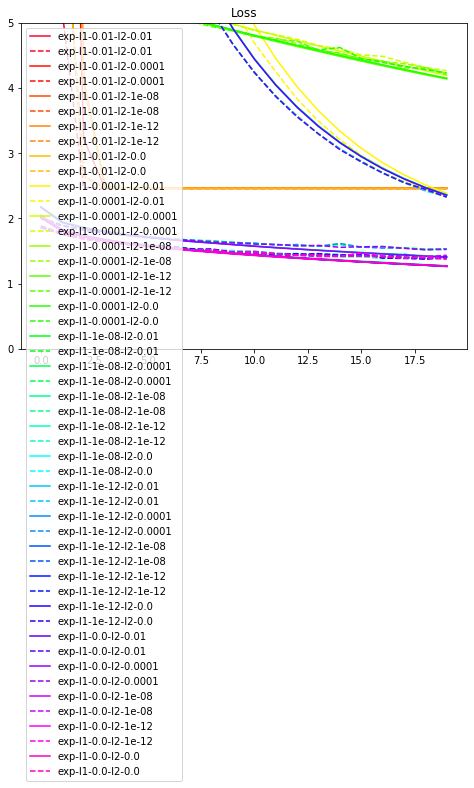

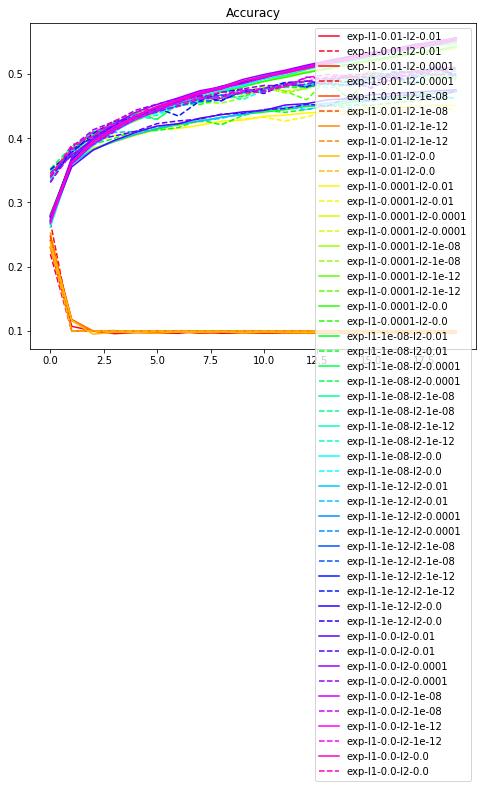

In [12]:
"""Code Here
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-accuracy'])),results[cond]['train-accuracy'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-accuracy'])),results[cond]['valid-accuracy'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()